In [1]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import signal
from scipy.stats import norm, pearsonr
from scipy.ndimage.filters import gaussian_filter
from itertools import combinations
%matplotlib inline

In [2]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

In [3]:
def scale_to_extreme(arr, thr):
    arr = np.asarray(arr)
    arr_min = arr.min()
    arr_max = arr.max()
    _arr = [arr_min if a < thr else arr_max for a in arr]
    return _arr

In [4]:
def extract_spectrogram_info(spectrogram_data):
    '''Extract the time, frequency axis values as well as the 
            spectrogram data.
    inputs:
        spectrogram_data: the spectrogram data including the 
        time and frequency information.
    outputs: 
        time: time values
        frequency: frequency values
        spectrogram: spectrogram
    '''
    time = spectrogram_data[0,1:]
    frequency = spectrogram_data[1:,0]
    spectrogram = spectrogram_data[1:,1:]
    return time, frequency, spectrogram

In [5]:
file_durations = []
site_recording_frq = 257
for awd_event in range(1,awd_events):
    for site in range(len(sites)):
        temp = []
        f  = h5py.File(database_path, 'r')
        grp_wh = f[os.path.join('awdEvents'+str(awd_event), sites[site],'split_dataset')]
        files = list(grp_wh.keys())
        for file in files:
            temp.append(grp_wh[file].shape[1])
        f.close()
        file_durations.append(np.asarray(temp))

In [9]:
site_recording_time = []
gaussian_site_noise = []
gaussian_mean = (0,0)
gaussian_cov = [[0,0],[0,1]]

for site in range(len(sites)):
    site_recording_time.append(file_durations[site].max())
    gaussian_site_noise.append(np.random.multivariate_normal(gaussian_mean, gaussian_cov, 
                                                             (site_recording_frq, site_recording_time[site]))[:,:,0])
site_recording_time
gaussian_site_noise[0].shape

(257, 2630)

In [7]:
def vstack_uneven(base_arr, added_arr):
    index = added_arr.shape[1]
    arr = np.zeros(shape=base_arr.shape)
    arr[:,:index] = added_arr + base_arr[:,:index]
    arr[:,index:] = base_arr[:,index:]
    return arr

# b = np.array([[-1,-1,-1,-1,-1,-1,-1,-1],[-2,-2,-2,-2,-2,-2,-2,-2],[-3,-3,-3,-3,-3,-3,-3,-3,]])
# a = np.array([[1,1,1],[1,1,1],[1,1,1]])
# print(b)
# print(a)
# print(vstack_uneven(b,a))

Number of files:  2196
2013-09-18UT23:52:20.23219430.marion.vr2
Spectrogram size:  (257, 895)
624 [416, 624, 895] [(416, 624), (416, 895), (624, 895)]
[[2000.46381   42.     ]
 [2000.51281   54.     ]
 [2000.53681   17.     ]
 [2000.54781   56.     ]
 [2000.58281   35.     ]
 [2000.61681   59.     ]
 [2000.64281   61.     ]
 [2000.66581  106.     ]
 [2000.70081   90.     ]
 [2000.72881   73.     ]
 [2000.74081   36.     ]
 [2999.77081   37.     ]]
416 624 (895,)
Spectrogram size:  (257, 1262)
416 895 (895,)
Spectrogram size:  (257, 1262)
624 895 (895,)
Spectrogram size:  (257, 1262)


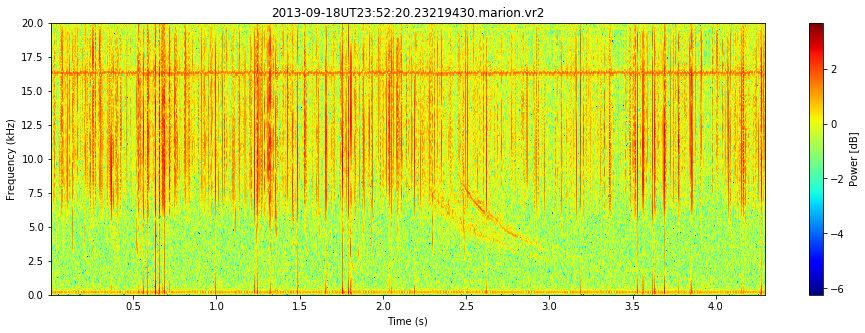

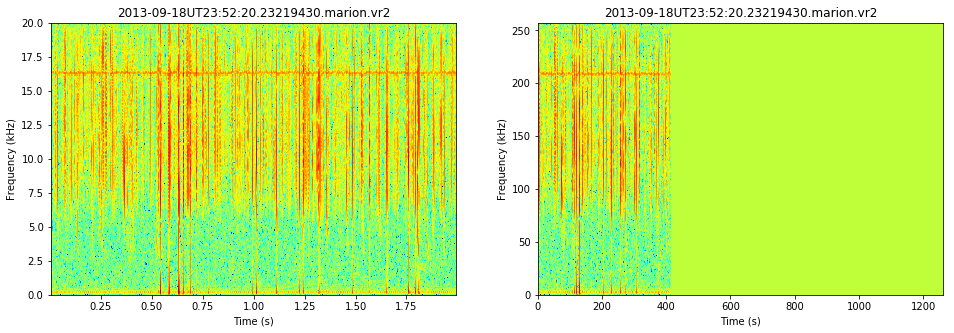

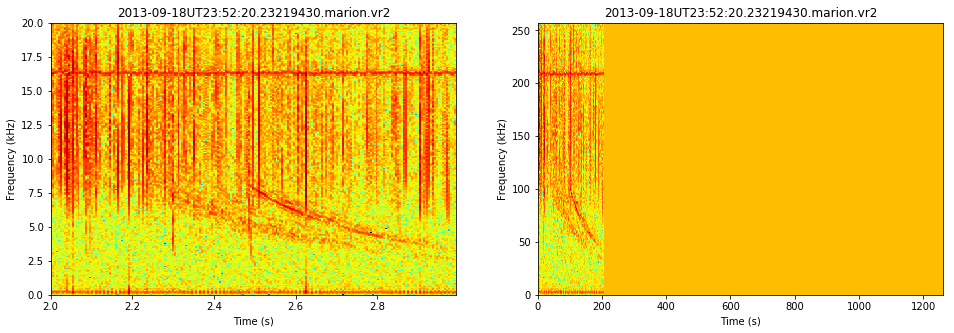

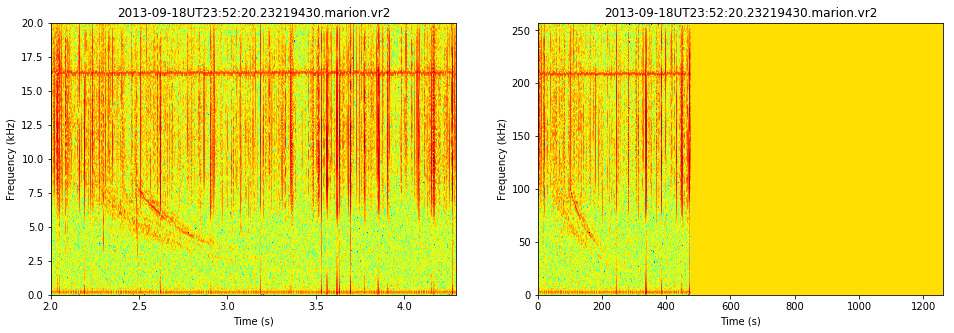

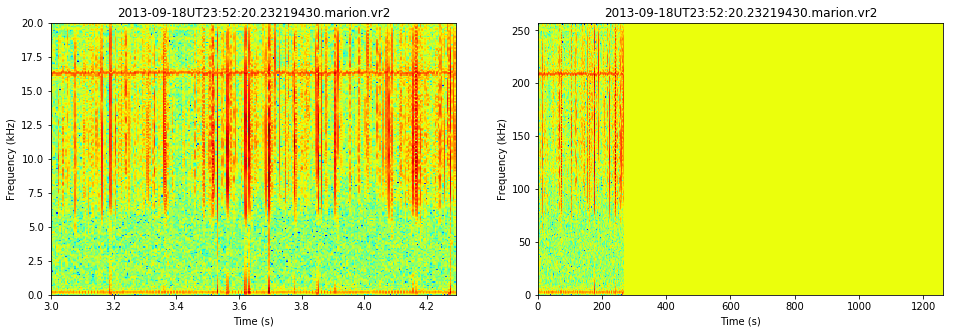

In [8]:
f  = h5py.File(database_path, 'r')
grp_wh = f[os.path.join('awdEvents'+str(1), sites[0],'spectrograms')]
files = list(grp_wh.keys())
print('Number of files: ', len(files))
file = files[np.random.randint(len(files))] # select a random sample
# file = '2013-07-26UT03:47:01.17731914.marion.vr2'
# file = '2013-07-05UT19:02:08.10851914.marion.vr2'
for k in range(1):
    print(file)
    # create np array to store sample information
    data = np.empty(grp_wh[file].shape)
    grp_wh[file].read_direct(data)
    outputs = grp_wh[file].attrs['output']
    # extract data info
    time, freq, Sxx = extract_spectrogram_info(data)
    
    mean = np.mean(Sxx)
    std = np.std(Sxx)
    
    Sxx -= mean 
    
    fig = plt.figure(figsize=(16,5))
    img = plt.pcolormesh(time,freq/1000,Sxx, cmap='jet')
    fig.colorbar(mappable=img, label='Power [dB]')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.title(file)
    print('Spectrogram size: ', Sxx.shape)
    _t = np.round_(time,decimals=3)
    index = 0
    indices = []
    for output in outputs:
        event_time = np.round(output[0]/1000,3)
        # find index of that event in the spectrogram
        index = min(range(len(_t)), key=lambda i: abs(_t[i]-event_time))
        # only process if the index found is new
        if index!=0 and index not in indices:
            indices.append(index)
    events = sorted(outputs[:,1], reverse=True)[:len(indices)] # map prob to to event correctly
    indices.append(time.shape[0])
    event_indices = list(combinations(indices,2))
    
    print(index,indices, list(event_indices))
    print(outputs)
    # get eventless section of spectrogram
    Sxx_no_event, dump = np.hsplit(Sxx, [indices[0]])
    t_no_event, dump = np.hsplit(time, [indices[0]])
    
    # compute histogram
    # get mean
    mean = np.mean(Sxx_no_event)
    std = np.std(Sxx_no_event)
    # Compute histogram
    (n, bins) = np.histogram(Sxx_no_event.flatten(), bins=100, density=True)  # NumPy version (no plot)
    # Compute pdf
    pdf = norm.pdf(bins, mean, std)
    
    fig = plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(t_no_event,freq/1000,Sxx_no_event, cmap='jet')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.title(file)
    # plot distribution
#     plt.subplot(2,2,2)
#     plt.plot(.5*(bins[1:]+bins[:-1]), n)
#     plt.plot(bins, pdf)
#     plt.title('PSD Distribution')
#     plt.xlabel('PSD')
#     plt.ylabel('Density')
#     plt.legend(['PSD distribution', 'Guassian distribution'])
    # expanding the spectrogram  
    plt.subplot(1,2,2)
    Sxx_no_event = vstack_uneven(gaussian_site_noise[site], Sxx_no_event)
#     Sxx_no_event *= mean
    plt.pcolormesh(Sxx_no_event, cmap='jet')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (kHz)')
    plt.title(file)
#     # compute histogram
#     # get mean
#     mean = np.mean(Sxx_no_event)
#     std = np.std(Sxx_no_event)
#     # Compute histogram
#     (n, bins) = np.histogram(Sxx_no_event.flatten(), bins=100, density=True)  # NumPy version (no plot)
#     # Compute pdf
#     pdf = norm.pdf(bins, mean, std)
#     # plot distribution
#     plt.subplot(2,2,4)
#     plt.plot(.5*(bins[1:]+bins[:-1]), n)
#     plt.plot(bins, pdf)
#     plt.title('PSD Distribution')
#     plt.xlabel('PSD')
#     plt.ylabel('Density')
#     plt.legend(['PSD distribution', 'Guassian distribution'])
    # get event sections of spectrogram
    for i in event_indices:
        print(i[0], i[1], time.shape)
        Sxx_event = Sxx[:,i[0]:i[1]]
        t_event = time[i[0]:i[1]]
        # compute histogram
        # get mean
        mean = np.mean(Sxx_no_event)
        std = np.std(Sxx_no_event)
        # Compute histogram
        (n, bins) = np.histogram(Sxx_no_event.flatten(), bins=100, density=True)  # NumPy version (no plot)
        # Compute pdf
        pdf = norm.pdf(bins, mean, std)
        plt.figure(figsize=(16,5))
        plt.subplot(1,2,1)
        plt.pcolormesh(t_event,freq/1000,Sxx_event, cmap='jet')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title(file)
#         plt.subplot(2,2,2)
#         plt.plot(.5*(bins[1:]+bins[:-1]), n)
#         plt.plot(bins, pdf)
#         plt.title('PSD Distribution')
#         plt.xlabel('PSD')
#         plt.ylabel('Density')
#         plt.legend(['PSD distribution', 'Guassian distribution'])
        # expanding the spectrogram  
        plt.subplot(1,2,2)
        Sxx_event = vstack_uneven(gaussian_site_noise[site], Sxx_event)
#         Sxx_event *= mean
        plt.pcolormesh(Sxx_event, cmap='jet')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title(file)
#         # compute histogram
#         # get mean
#         mean = np.mean(Sxx_event)
#         std = np.std(Sxx_event)
#         # Compute histogram
#         (n, bins) = np.histogram(Sxx_event.flatten(), bins=100, density=True)  # NumPy version (no plot)
#         # Compute pdf
#         pdf = norm.pdf(bins, mean, std)
#         # plot distribution
#         plt.subplot(2,2,4)
#         plt.plot(.5*(bins[1:]+bins[:-1]), n)
#         plt.plot(bins, pdf)
#         plt.title('PSD Distribution')
#         plt.xlabel('PSD')
#         plt.ylabel('Density')
#         plt.legend(['PSD distribution', 'Guassian distribution'])
        print('Spectrogram size: ', Sxx_event.shape)
    break
f.close()

perfect distribution

2013-07-10UT19:19:44.00611938.marion.vr2

off

2013-07-26UT03:38:16.07011914.marion.vr2
2013-07-02UT16:04:12.19171914.marion.vr2
2013-07-04UT18:43:52.37731922.marion.vr2

strange distribution

2013-10-20UT22:36:37.25619422.marion.vr2

long

2013-07-26UT03:47:01.17731914.marion.vr2  # one event is blank
2013-05-18UT13:43:46.27112156.marion.vr2

wrong label
